In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#from statannotations.Annotator import Annotator #https://github.com/trevismd/statannotations
from scipy.stats import friedmanchisquare

from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# if getting OptionError: "No such keys(s): 'mode.use_inf_as_null'"
# !pip install --upgrade seaborn pandas

import os
from glob import glob

if not os.path.exists('../paper/figs'):
    os.makedirs('../paper/figs')

from _load_data import * # Getting our specific labels, formatting, and data

from _cd_diagram import draw_cd_diagram

# Getting some free samples
results_df.sample(3)

# Don't change any code below, it may break (probably will) --------------------



['../models/SimplifierBottomUp.py', '../models/SimplifierBottomUpOnlyLast.py', '../models/SimplifierTopDown.py', '../models/Vanilla.py', '../models/SimplifierTopDownOnlyLast.py'] ['Bottom Up', 'Bottom Up (only last)', 'Top Down', 'Without simplify', 'Top Down (only last)']
(750, 14)
['Bottom Up' 'Bottom Up (only last)' 'Top Down' 'Without simplify'
 'Top Down (only last)']
['Airfoil' 'Concrete' 'Energy Cooling' 'Energy Heating' 'Housing']


,model,dataset,RunID,random_state,time,date,train_r2,test_r2,train_mse,test_mse,representation,size,complexity,depth
125,Top Down (only last),Airfoil,0,26311,768.319961,01-17-2024 02:18:11,0.507818,0.471245,15.899760,17.411378,"cdiv(add3(x_2, 1645.4635192842077, x_3), log1p(add4(mul4(32.258550987291244, x_4, multiply(x_0, x_2), add3(x_0, 2682.0820432421224, x_1)), x_1, 158766.66678508648, 292975.4125524577)))",20,9328,5
246,Without simplify,Concrete,0,10132,198.943211,01-17-2024 03:47:06,0.456246,0.513666,98.574019,85.330126,"add(subtract(mul4(add3(x_7, x_0, 93.32861979842492), add4(x_1, x_5, x_2, x_1), 6.674037365797831e-08, add4(x_1, x_0, 582.6118470659877, x_2)), mul3(-0.01926959485744146, x_7, x_4)), -0.46610142524736137)",23,1348,4
639,Bottom Up (only last),Housing,0,19863,149.856516,01-17-2024 06:06:11,0.571727,0.347819,24.831582,35.758107,"subtract(14.191120969043387, multiply(maximum(add3(x_5, x_11, -108.8174977031923), -86.41198622410037), multiply(-0.0008513029198804551, cdiv(exp(minimum(7.56842143235075, x_5)), x_10))))",17,95,6


criteria              Harmonic Mean size mean score                      \
                               mean              lb      mean        ub   
model                                                                     
Top Down (only last)       3.040650        2.608363  2.750000  2.891637   
Bottom Up                  2.998023        3.149801  3.370000  3.590199   
Top Down                   2.961991        3.174853  3.406667  3.638481   
Without simplify           2.922278        2.679283  2.813333  2.947384   
Bottom Up (only last)      2.921492        2.443663  2.660000  2.876337   

criteria              test_mse mean score                  
                                       lb  mean        ub  
model                                                      
Top Down (only last)             3.258363  3.40  3.541637  
Bottom Up                        2.445288  2.70  2.954712  
Top Down                         2.317349  2.62  2.922651  
Without simplify                 2.854751  3.04  3.225249  
Bottom Up (only last)            3.064209  3.24  3.415791

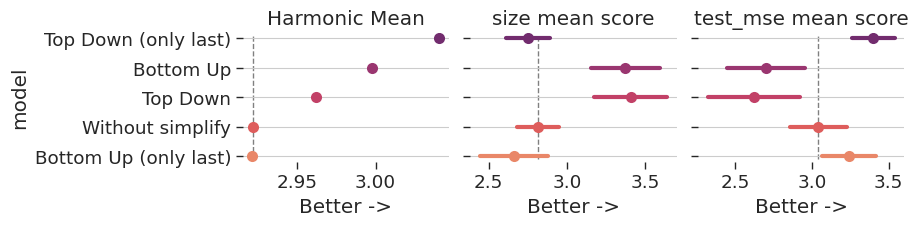

criteria              Harmonic Mean complexity mean score                      \
                               mean                    lb      mean        ub   
model                                                                           
Bottom Up                  3.183416              3.024176  3.210000  3.395824   
Top Down                   3.135610              2.967859  3.250000  3.532141   
Without simplify           2.934441              2.635664  2.926667  3.217670   
Bottom Up (only last)      2.832296              2.484915  2.840000  3.195085   
Top Down (only last)       2.819165              2.481050  2.773333  3.065617   

criteria              depth mean score                     size mean score  \
                                    lb      mean        ub              lb   
model                                                                        
Bottom Up                     3.211565  3.513333  3.815101        3.149801   
Top Down                      2.875572  3.240000  3.604428        3.174853   
Without simplify              2.687145  2.896667  3.106188        2.679283   
Bottom Up (only last)         2.397922  2.770000  3.142078        2.443663   
Top Down (only last)          2.264912  2.580000  2.895088        2.608363   

criteria                                  test_mse mean score                  \
                           mean        ub                  lb  mean        ub   
model                                                                           
Bottom Up              3.370000  3.590199            2.445288  2.70  2.954712   
Top Down               3.406667  3.638481            2.317349  2.62  2.922651   
Without simplify       2.813333  2.947384            2.854751  3.04  3.225249   
Bottom Up (only last)  2.660000  2.876337            3.064209  3.24  3.415791   
Top Down (only last)   2.750000  2.891637            3.258363  3.40  3.541637   

criteria              test_r2 mean score                      
                                      lb      mean        ub  
model                                                         
Bottom Up                       2.989890  3.253333  3.516777  
Top Down                        3.025916  3.300000  3.574084  
Without simplify                2.827271  3.006667  3.186063  
Bottom Up (only last)           2.489386  2.720000  2.950614  
Top Down (only last)            2.541558  2.720000  2.898442

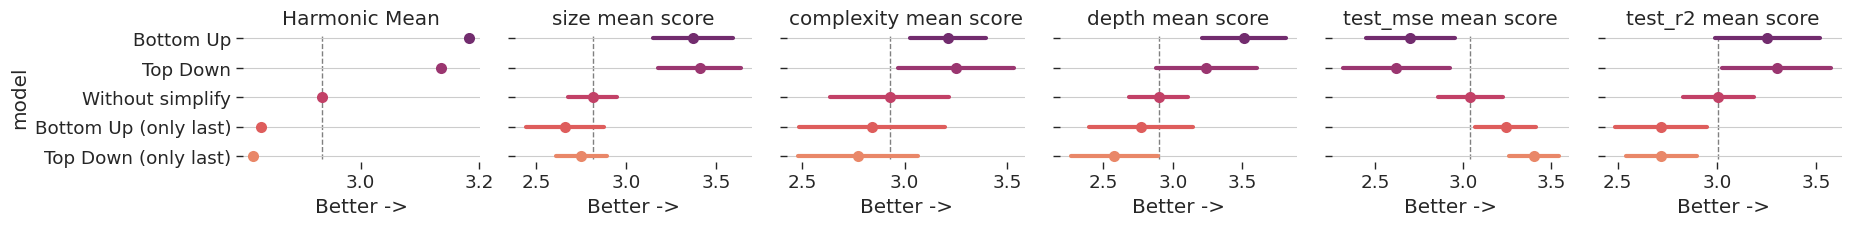

criteria              Harmonic Mean complexity mean score                      \
                               mean                    lb      mean        ub   
model                                                                           
Bottom Up                  3.183416              3.024176  3.210000  3.395824   
Top Down                   3.135610              2.967859  3.250000  3.532141   
Without simplify           2.934441              2.635664  2.926667  3.217670   
Bottom Up (only last)      2.832296              2.484915  2.840000  3.195085   
Top Down (only last)       2.819165              2.481050  2.773333  3.065617   

criteria              depth mean score                     size mean score  \
                                    lb      mean        ub              lb   
model                                                                        
Bottom Up                     3.211565  3.513333  3.815101        3.149801   
Top Down                      2.875572  3.240000  3.604428        3.174853   
Without simplify              2.687145  2.896667  3.106188        2.679283   
Bottom Up (only last)         2.397922  2.770000  3.142078        2.443663   
Top Down (only last)          2.264912  2.580000  2.895088        2.608363   

criteria                                  test_mse mean score                  \
                           mean        ub                  lb  mean        ub   
model                                                                           
Bottom Up              3.370000  3.590199            2.445288  2.70  2.954712   
Top Down               3.406667  3.638481            2.317349  2.62  2.922651   
Without simplify       2.813333  2.947384            2.854751  3.04  3.225249   
Bottom Up (only last)  2.660000  2.876337            3.064209  3.24  3.415791   
Top Down (only last)   2.750000  2.891637            3.258363  3.40  3.541637   

criteria              test_r2 mean score                      
                                      lb      mean        ub  
model                                                         
Bottom Up                       2.989890  3.253333  3.516777  
Top Down                        3.025916  3.300000  3.574084  
Without simplify                2.827271  3.006667  3.186063  
Bottom Up (only last)           2.489386  2.720000  2.950614  
Top Down (only last)            2.541558  2.720000  2.898442

In [2]:
def plot_rankings(columns, results_df, path):
    ranks_data = []
    for col in columns:
        ranks_df = results_df.pivot( # Smaller is better for all columns here
            index=['dataset', 'RunID', 'random_state'], columns='model', values=col
        ).rank(ascending=False, axis=1).groupby('dataset').mean()#.rank(ascending=False, axis=1)
        
        for model in results_df['model'].unique():
            df_model = ranks_df[ model ]
            values = df_model.values

            # Estimating lower and upper confidence bounds
            lb, ub = stats.norm.interval(confidence=0.95, loc=np.mean(values),
                                        scale=stats.sem(values))
            lb = np.nan_to_num(lb, 0.0)
            ub = np.nan_to_num(ub, 0.0)

            ranks_data.append( (model, f'{col} mean score', df_model.mean(), lb, ub) )

    # Creating the dataframe
    ranks_data_df = pd.DataFrame(data=ranks_data,
                                columns=['model', 'criteria', 'mean', 'lb', 'ub'])

    ranks_data_df = ranks_data_df.pivot(columns='criteria', index='model')

    # will calculate the harmonic mean and plot the columns based on mean rankings
    ranks_data_df[('mean', 'Harmonic Mean')] = (
        ranks_data_df[[('mean', f'{col} mean score') for col in columns]]
    )['mean'].apply(stats.hmean, axis=1)

    ranks_data_df = ranks_data_df.sort_values(by=('mean', 'Harmonic Mean'), ascending=False)
    ranks_data_df = ranks_data_df.reorder_levels([1, 0], axis=1).sort_index(axis=1)

    display(ranks_data_df)
    #print(ranks_data_df.to_latex())

    # Use semantically meaningful titles for the columns
    titles = ['Harmonic Mean']+[f'{col} mean score' for col in columns]

    # Now making the plot
    g = sns.PairGrid(ranks_data_df.reorder_levels([1, 0], axis=1)['mean'].reset_index(),
                    x_vars=titles, y_vars=['model'], height=2.5, aspect=1.25)

    # Draw a dot plot using the stripplot function
    g.map(sns.stripplot, size=8, orient="h", jitter=False,
        palette="flare_r", linewidth=0, edgecolor="w")

    # setting the reference as the Baseline 
    unif = ((ranks_data_df[ ranks_data_df.index=='Without simplify'])['Harmonic Mean'])['mean'].values[0]
    g.axes.flat[0].axvline(x=unif, ymin=0.025, ymax=0.975, color='gray', ls='--', zorder=-999)

    g.axes.flat[0].set(title='Harmonic Mean')
    g.axes.flat[0].set_xlabel('Better ->')
    #g.axes.flat[0].set_xlim( (-1, len(ranks_data_df.index)+1) )

    # Make the grid horizontal instead of vertical
    g.axes.flat[0].xaxis.grid(False)
    g.axes.flat[0].yaxis.grid(True)

    for ax, title in zip(g.axes.flat[1:], titles[1:]):
        color = iter(sns.color_palette("flare_r", ranks_data_df.shape[0]))
        for tick, text in zip(g.axes.flat[0].get_yticks(), g.axes.flat[0].get_yticklabels()):
            c=next(color)
            sample_name = text.get_text()  # "X" or "Y"
            single_df = ranks_data_df[ ranks_data_df.index==sample_name ]
            
            lb, ub, mean_val = (single_df[title])[ ['lb', 'ub', 'mean'] ].values[0]
            rank_val = ranks_data_df.reset_index()[(ranks_data_df.reset_index()['model']==sample_name)].index

            # plot horizontal lines across the column, centered on the tCIk
            ax.plot([lb, ub], [rank_val, rank_val], lw=3, color=c)

        # Draw a reference line on baseline
        unif = (ranks_data_df[ ranks_data_df.index=='Without simplify'])[(title, 'mean')].values[0]
        ax.axvline(x=unif, ymin=0.025, ymax=0.975, color='gray', ls='--', zorder=-999)

        # Set a different title for each axes
        ax.set(title=title)
        ax.set_xlabel('Better ->')
        #ax.set_xlim( (-1, len(ranks_data_df.index)+1) )

        # Make the grid horizontal instead of vertical
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)

    sns.despine(left=True, bottom=True)

    plt.tight_layout()
    plt.savefig(f'{path}.pdf')
    plt.savefig(f'{path}.png', dpi=600)

    plt.show()

    return ranks_data_df

plot_rankings(['size', 'test_mse'], results_df, "../paper/figs/size_mse")
plot_rankings(['size', 'complexity', 'depth', 'test_mse', 'test_r2'], results_df, "../paper/figs/size_mse_compexity_depth")
